In this notebook we'll examine the differences between concrete and abstract models.  The Pyomo documentation also discusses this but does not provide very good code examples to illustrate the differences: https://pyomo.readthedocs.io/en/latest/pyomo_overview/abstract_concrete.html

# Pizza LP as a Concrete Model

Concrete models in Pyomo are ones where the __data (parameters) are hard-coded into the model__.  This is the kind of model we have been building so far.  First, let's read in the data (parameters) that will be used in the objective function and constraints.

First, let's manually re-organize the data from the original spreadsheet model ('../hw3/Homework 3 OMs.xlsx') so that it's easy to read into pandas.

In [1]:
import pandas as pd

# Read in the data first
profit = pd.read_excel('pizza-lp-munged.xlsx', sheet_name='profit', index_col=0)
resources = pd.read_excel('pizza-lp-munged.xlsx', sheet_name='resources', index_col=0)
rhs = pd.read_excel('pizza-lp-munged.xlsx', sheet_name='rhs', index_col=0)

Here is the concrete model we built for the "pizza" problem in HW 3.  Notice that the parameters in the `coef` and `rhs` dataframes are written directly into the constraints, and we have to have one line per constraint.  In a way, this is silly, because the constraints all have the same form (sumproduct <= rhs).  If we had 10's or 100's or more constraints, this gets pretty inefficient!

In [2]:
import pyomo.environ as pe

model = pe.ConcreteModel()

# Decision variables
decision_index = list(range(4))
model.x = pe.Var(decision_index, domain=pe.NonNegativeReals)

# Objective function
model.obj = pe.Objective(expr=sum([profit.iloc[i, 0]*model.x[i] for i in decision_index]), 
                         sense=-1)

# Constraints
model.cons_dough = pe.Constraint(expr=sum([resources.iloc[0, i]*model.x[i] for i in decision_index]) <= rhs.iloc[0, 0])
model.cons_sauce = pe.Constraint(expr=sum([resources.iloc[1, i]*model.x[i] for i in decision_index]) <= rhs.iloc[1, 0])
model.cons_cheese = pe.Constraint(expr=sum([resources.iloc[2, i]*model.x[i] for i in decision_index]) <= rhs.iloc[2, 0])
model.cons_meat = pe.Constraint(expr=sum([resources.iloc[3, i]*model.x[i] for i in decision_index]) <= rhs.iloc[3, 0])
model.cons_veggie = pe.Constraint(expr=sum([resources.iloc[4, i]*model.x[i] for i in decision_index]) <= rhs.iloc[4, 0])

# Pizza LP as an Abstract Model

Abstract models in Pyomo do not refer to specific data values.  For this reason, you could have many instances of a model that all use different data coming from different sources.  Here is what the abstract version of the pizza model would look like.

The first thing we have to do is start using abstract indexes.  This lets us "loop" over the constraints without having to write out each one explicitly.

In [3]:
# No more concrete model!
model = pe.AbstractModel()

# Decision variables are defined by an index object rather than a list.
model.pizza = pe.RangeSet(1, resources.shape[1])    # decisions are four pizza types
model.resource = pe.RangeSet(1, resources.shape[0]) # there are 5 resources

# Decision variables definition
model.x = pe.Var(model.pizza, domain=pe.NonNegativeReals)

Now everything (constraints, decisions, and objective) are defined in terms of these.  We cannot make reference to dataframes or other non-Pyomo objects.  Instead, we need to use the pyomo `Param` object to store our parameters.  We can use the helper function `df_to_dict` defined below to convert dataframes to dictionaries.

In [4]:
import numpy as np

def convert_1d_array_to_dict(arr):
    '''Converts a 1-d ndarray, DataFrame, or Series to a paramater dictionary.'''
    if isinstance(arr, pd.DataFrame) or isinstance(arr, pd.Series):
        arr = arr.values
    arr = arr.squeeze()
    if np.shape(arr) == ():
        arr = np.array([arr])
    return {(i+1): arr[i] for i in range(len(arr))}


def convert_2d_array_to_dict(arr):
    '''Converts a 2-d ndarray, DataFrame or Series to a parameter dictionary.'''
    if isinstance(arr, pd.DataFrame) or isinstance(arr, pd.Series):
        arr = arr.values
    return {(i+1,j+1): arr[i,j] for i in range(arr.shape[0]) for j in range(arr.shape[1])}


# To enable the model to be "abstract", we use a Param object to store the data.
profit_dict = convert_1d_array_to_dict(profit)
model.profit_coef = pe.Param(model.pizza, initialize=profit_dict)

resource_dict = convert_2d_array_to_dict(resources)
model.resource_coef = pe.Param(model.resource, model.pizza, initialize=resource_dict)

rhs_dict = convert_1d_array_to_dict(rhs)
model.resource_rhs = pe.Param(model.resource, initialize=rhs_dict)

Now everything is defined w.r.t. these `Param` objects, no reference to specific data values!  The trade-off is that now constraints and objectives use the `rule=` argument which is a function that defines the value of that model component.

In [5]:
def objective_rule(model):
    return sum(model.profit_coef[p] * model.x[p] for p in model.pizza)
model.obj = pe.Objective(rule=objective_rule, sense=-1)

def resource_rule(model, r):
    return sum(model.resource_coef[r, p] * model.x[p] for p in model.pizza) <= model.resource_rhs[r]
model.resource_cons = pe.Constraint(model.resource, rule=resource_rule)

In [6]:
# This is how you solve!
instance = model.create_instance()
opt = pe.SolverFactory('glpk')
result = opt.solve(instance, tee=True)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/j6/vzm_9p_j4_x08rrgkr0f7cb84vgyj9/T/tmpmxsc90xl.glpk.raw
 --wglp /var/folders/j6/vzm_9p_j4_x08rrgkr0f7cb84vgyj9/T/tmp9wjxivd3.glpk.glp
 --cpxlp /var/folders/j6/vzm_9p_j4_x08rrgkr0f7cb84vgyj9/T/tmp64ud9f7d.pyomo.lp
Reading problem data from '/var/folders/j6/vzm_9p_j4_x08rrgkr0f7cb84vgyj9/T/tmp64ud9f7d.pyomo.lp'...
6 rows, 5 columns, 17 non-zeros
51 lines were read
Writing problem data to '/var/folders/j6/vzm_9p_j4_x08rrgkr0f7cb84vgyj9/T/tmp9wjxivd3.glpk.glp'...
41 lines were written
GLPK Simplex Optimizer, v4.65
6 rows, 5 columns, 17 non-zeros
Preprocessing...
5 rows, 4 columns, 16 non-zeros
Scaling...
 A: min|aij| =  2.000e+00  max|aij| =  5.000e+00  ratio =  2.500e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 5
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (4)
*     2: obj =   4.000000000e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTI

In [7]:
# Make sure you check for infeasibility or unbounded solutions...
print(result)


Problem: 
- Name: unknown
  Lower bound: 400.0
  Upper bound: 400.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 5
  Number of nonzeros: 17
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.02816009521484375
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [8]:
# This is how you get the objective... here "obj" is what you named the objective object
# when you created the model.
instance.obj.expr()

400.0

The helper function below will extract your decision variables as a pandas dataframe.

In [10]:
import pyomo

def parse_solution(model, instance, index=None):

    # Extract variable names
    var = [x for x in instance.component_map().keys() 
           if isinstance(getattr(instance, x), pyomo.core.base.var.IndexedVar)]
    
    # Create dataframe, distinguising between first and second stage variables
    dfs = []
    for v in var:
        df = pd.DataFrame([x.value for x in instance.component_map()[v].values()], columns=[v])
        dfs.append(df)
    dfs = pd.concat(dfs, axis=1)
    
    if index is not None:
        dfs.index = index
        
    return dfs


df = parse_solution(model, instance, index=resources.columns)

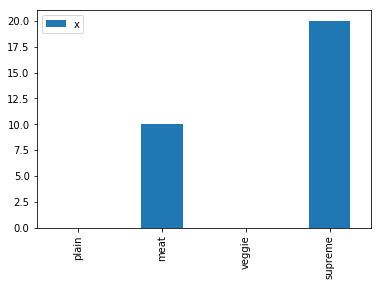

In [11]:
%matplotlib inline
_ = df.plot(kind='bar')